In [1]:
import xarray as xr
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.sparse.linalg import svds
from functools import partial
import seaborn as sns 

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def get_monthly_anomalies(new_data):

    climat = new_data.groupby('time.month').mean(dim='time', skipna=True)
    anoms = new_data.groupby('time.month') - climat 

    return anoms

In [3]:
def partition_timescales(data, sample_freq):
    
    years = len(data.time)/sample_freq
    
    anomalies = get_monthly_anomalies(data)
    filtered_data = butterworth_filter2(sample_freq, years, anomalies)
    
    variability = filtered_data #.std(dim = 'time')
    # sit_sic_cov = xr.cov(filtered_data.sithick, filtered_data.siconc, dim = 'time')
#     siv_sia_cov = xr.cov(filtered_data.SIV, filtered_data.SIA, dim = 'time')
    
    # variability['sit_sic_cov'] = sit_sic_cov
#     variability['siv_sia_cov'] = siv_sia_cov
    
    return variability

In [4]:
def butterworth_filter2(sample_freq, years, anomalies):
    
    # set up cutoffs
    nyquist = 1/2
    nints = sample_freq * years
    dec_cutoff = 1/nints * 1/nyquist
    a2d_cutoff = 1/(sample_freq*1.5) * 1/nyquist
    ann_cutoff = 1/(sample_freq*0.5) * 1/nyquist
    
    # form filters
    s2s_sos = signal.butter(4, ann_cutoff, 'hp', output='sos')
    ann_sos = signal.butter(4, [a2d_cutoff, ann_cutoff], 'bp', output='sos')
    a2d_sos = signal.butter(4, a2d_cutoff, 'lp', output='sos')
    
    # perform filtering
    s2s_filt = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    ann_filt = xr.apply_ufunc(partial(signal.sosfilt, ann_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    a2d_filt = xr.apply_ufunc(partial(signal.sosfilt, a2d_sos),
                              anomalies,
                              output_dtypes=[anomalies.sithick.dtype],
                              kwargs={'axis': 0})
    
    # concatenate
    filtered_data = xr.concat([s2s_filt, ann_filt, a2d_filt], dim = 'timescale')
    
    # assign coordinates
    filtered_data = filtered_data.assign_coords({'timescale':['s2s','ann','a2d']})
    
    return filtered_data

In [5]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap, ax):
    """ plot a NorthPolarStereo map """
    
    data = data_array
    lat = data_array.latitude
    lon = data_array.longitude
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    # fig = plt.figure(figsize = (6,6))
    # ax = plt.gca() #axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 6)
    clevs = np.linspace(bounds[0], bounds[1], 16)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

### CS2

In [6]:
file = '../data/cryosat-2/cryosat-2/cs2_landy_data.nc'
data = xr.open_dataset(file)

# limit to 2011-2020 (get rid of nasty residual tracks in 2010)
data = data.isel(time = slice(6, -1))
data['siconc'] = data.siconc.where(np.isnan(data.siconc) != True, 0)
data['sithick'] = data.sithick.where(np.isnan(data.sithick) != True, 0)
data['siarea'] = data.siarea.where(np.isnan(data.siarea) != True, 0)
data['sivol'] = data.sivol.where(np.isnan(data.sivol) != True, 0)

In [7]:
variability = partition_timescales(data, 24)
anomalies = get_monthly_anomalies(data)

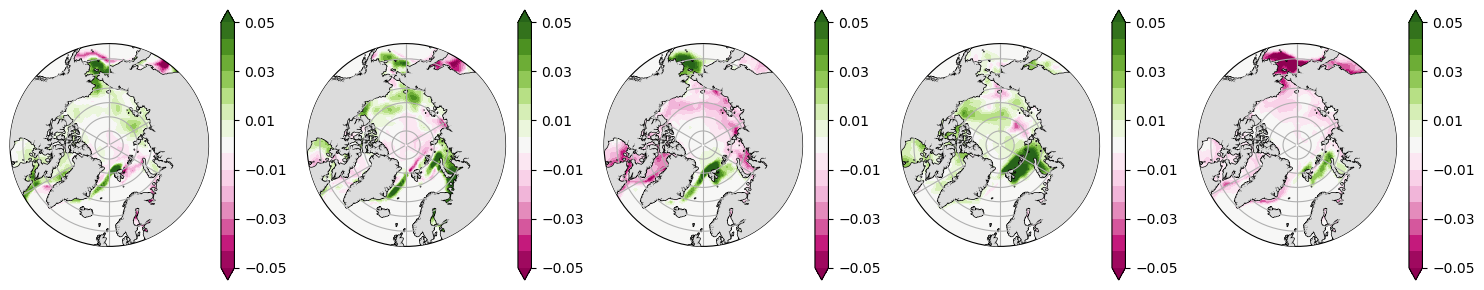

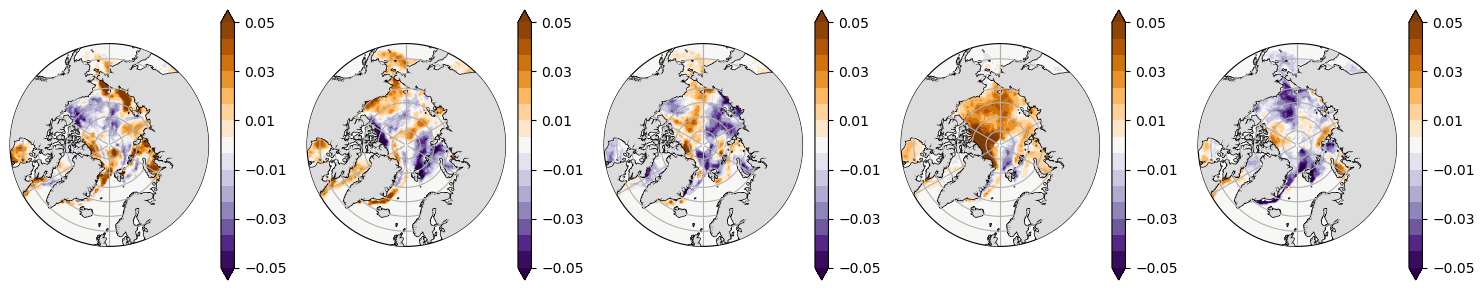

In [31]:
# in the anomaly space
lag = 22
thing = 1/(len(anomalies.time)-1)*(anomalies.sithick.stack({'space':['x','y']})[:-lag,:].transpose().values @ anomalies.siconc.stack({'space':['x','y']})[lag:].values)
U,S1,V = svds(thing, k = 5)

fig, axes = plt.subplots(ncols = 5, figsize = (15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0,5):
    anomalies['V'+str(i)] = (['x','y'], V[i].reshape(100,100))
    plot_nps(anomalies['V'+str(i)], [-0.05, 0.05], plt.cm.PiYG, axes[i])
    
plt.tight_layout()
    
fig, axes = plt.subplots(ncols = 5, figsize = (15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,5):
    anomalies['U'+str(i)] = (['x','y'], U[:,i].reshape(100,100))
    plot_nps(anomalies['U'+str(i)], [-0.05, 0.05], plt.cm.PuOr_r, axes[i])
    
plt.tight_layout()


<ErrorbarContainer object of 3 artists>

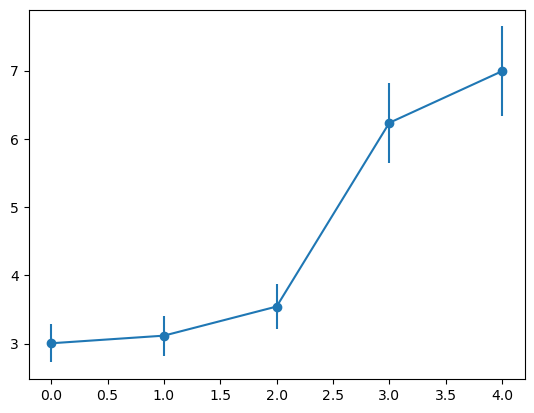

In [32]:
dof  = len(anomalies.time) - 1
delta = S1 * np.sqrt(2/dof)
plt.scatter(x = range(0,5), y = S1)
plt.errorbar(x = range(0,5), y = S1, yerr = delta)

### PIOMAS

In [6]:
file = '/glade/work/mollyw/Projects/sea_ice_covariability/data/cryosat-2/piomas/piomas_biweekly_data.nc'
pdata = xr.open_dataset(file)

# limit to 2011-2020 (get rid of nasty residual tracks in 2010)
pdata = pdata.isel(time = slice(6, -1))
pdata['siconc'] = pdata.siconc.where(np.isnan(pdata.siconc) != True, 0)
pdata['sithick'] = pdata.sithick.where(np.isnan(pdata.sithick) != True, 0)
pdata['siarea'] = pdata.siarea.where(np.isnan(pdata.siarea) != True, 0)
pdata['sivol'] = pdata.sivol.where(np.isnan(pdata.sivol) != True, 0)

In [7]:
variability = partition_timescales(pdata, 24)
anomalies = get_monthly_anomalies(pdata)

In [ ]:
# in the anomaly space
thing = 1/(len(anomalies.time)-1)*(anomalies.sithick.stack({'space':['x','y']}).transpose().values @ anomalies.siconc.stack({'space':['x','y']}).values)
U,S,V = svds(thing, k = 5)

fig, axes = plt.subplots(ncols = 5, figsize = (15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for i in range(0,5):
    anomalies['V'+str(i)] = (['x','y'], V[i].reshape(120,360))
    plot_nps(anomalies['V'+str(i)], [-0.05, 0.05], plt.cm.PiYG_r, axes[i])
    
plt.tight_layout()
    
fig, axes = plt.subplots(ncols = 5, figsize = (15,3), subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,5):
    anomalies['U'+str(i)] = (['x','y'], U[:,i].reshape(120,360))
    plot_nps(anomalies['U'+str(i)], [-0.05, 0.05], plt.cm.PuOr_r, axes[i])
    
plt.tight_layout()